# Real Time Gait Asymmetry Detection  

In this notebook we are going to achieve the following:

1. **Create the Training Dataset**: We will preprocess and combine data from different sources to create a comprehensive training dataset for real time gait asymmetry detection.
2. **Feature Selection and Dimensionality Reduction**: We will identify the most relevant features for real time gait asymmetry detection using dimensionality reduction techniques.
3. **Model Evaluation**: We will test and compare the performance of multiple machine learning and deep learning algorithms for real time gait asymmetry detection.

In [4]:
# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras import Input
from feature_extraction import generate_rolling_windows
from data_preprocessing import clean_extra_files, detection_merge_subject_features, detection_merge_raw_npz_files, detection_merge_csv_datasets, detection_merge_npz_datasets


# Constants
base_dir    = 'Data'
healthy_dir = 'Data/Healthy'
stroke_dir  = 'Data/Stroke'

detection_time_domain_name = 'detection_time_domain.csv'
detection_asymmetry_name   = 'detection_asymmetry.csv'

## Data Preprocessing, Feature Selection and Dimensionality Reduction

The first step is to create the dataset for the gait asymmetry and extract meaningful features from raw data. The goal is to create a set of different datasets that will provide a holistic view and different insights that we can use with the aim of creating a model that will provide a real time gait asymmetry detection. The process here includes the following steps:
1. Create a new base dataset that includes data in 2 second windows and a 1 second stride.
2. Extract simple statistic features from the 2 second signal like max, min and std. The simple statistics proved to be meaningful information for the classification task.
3. Extract a set of simple symmetry and asymmetry features from swing and stride times.

The data provided were designed for classification, since we have only a label for the whole signal as either 'Stroke Patient' or 'Healthy Subject'. In order to create the new real time asymmetry detection model we need to ensure that we have the correct labels. According to [Physio-pedia](https://www.physio-pedia.com/The_Gait_Cycle) the average gait cycle of a healthy adult is [1.2, 1.8] seconds. Taking into consideration the fact that impaired patients tend to have a longer stride we choose to use a 2 second window with a 1 second stride.

In [2]:
# Create the new datasets for the healthy subjects

# 1. Create all the feature files for the statistical, asymmetry and raw data 
for patient_id in os.listdir(healthy_dir):
    patient_path = os.path.join(healthy_dir, patient_id)
    
    if not os.path.isdir(patient_path) or patient_path.__contains__('.DS_Store'):
        continue
    
    try:
        generate_rolling_windows(patient_path)
    except Exception as e:
        print(f'Error processing {patient_id}: {e}')
        
# 2. Merge all type of datasets into a single file for better training
detection_merge_subject_features(healthy_dir, detection_time_domain_name, detection_time_domain_name)
detection_merge_subject_features(healthy_dir, detection_asymmetry_name, detection_asymmetry_name)
detection_merge_raw_npz_files(healthy_dir)

Generated and saved all 3 datasets to: Data/Healthy/Patient_8
Generated and saved all 3 datasets to: Data/Healthy/Patient_1
Generated and saved all 3 datasets to: Data/Healthy/Patient_6
Generated and saved all 3 datasets to: Data/Healthy/Patient_7
Generated and saved all 3 datasets to: Data/Healthy/Patient_9
Generated and saved all 3 datasets to: Data/Healthy/Patient_5
Generated and saved all 3 datasets to: Data/Healthy/Patient_2
Generated and saved all 3 datasets to: Data/Healthy/Patient_3
Generated and saved all 3 datasets to: Data/Healthy/Patient_4
Merged 9 files into detection_time_domain.csv
Merged 9 files into detection_asymmetry.csv
Merged 9 files into all_subject_raw_windows.npz


In [3]:
# Create the new datasets for the stroke patients

# 1. Create all the feature files for the statistical, asymmetry and raw data 
for patient_id in os.listdir(stroke_dir):
    patient_path = os.path.join(stroke_dir, patient_id)
    
    if not os.path.isdir(patient_path) or patient_path.__contains__('.DS_Store'):
        continue
    
    try:
        generate_rolling_windows(patient_path)
    except Exception as e:
        print(f'Error processing {patient_id}: {e}')
        
# 2. Merge all type of datasets into a single file for better training
detection_merge_subject_features(stroke_dir, detection_time_domain_name, detection_time_domain_name)
detection_merge_subject_features(stroke_dir, detection_asymmetry_name, detection_asymmetry_name)
detection_merge_raw_npz_files(stroke_dir)

Generated and saved all 3 datasets to: Data/Stroke/Patient_8
Generated and saved all 3 datasets to: Data/Stroke/Patient_1
Generated and saved all 3 datasets to: Data/Stroke/Patient_6
Generated and saved all 3 datasets to: Data/Stroke/Patient_7
Generated and saved all 3 datasets to: Data/Stroke/Patient_9
Generated and saved all 3 datasets to: Data/Stroke/Patient_5
Generated and saved all 3 datasets to: Data/Stroke/Patient_2
Generated and saved all 3 datasets to: Data/Stroke/Patient_3
Generated and saved all 3 datasets to: Data/Stroke/Patient_4
Merged 9 files into detection_time_domain.csv
Merged 9 files into detection_asymmetry.csv
Merged 9 files into all_subject_raw_windows.npz


In [4]:
# Merge the healthy subjects and stroke patients to a single file
detection_merge_csv_datasets(healthy_dir, stroke_dir, detection_time_domain_name)
detection_merge_csv_datasets(healthy_dir, stroke_dir, detection_asymmetry_name)
detection_merge_npz_datasets(base_dir)

Saved dataset detection_time_domain.csv with shape (4826, 16) to detection_time_domain.csv
Saved dataset detection_asymmetry.csv with shape (4826, 10) to detection_asymmetry.csv
Merged 2 files into all_subject_raw_windows.npz


## Gait Asymmetry Detection — Time-Domain Feature Model

This part of the notebook trains a binary classifier to detect gait asymmetry using time-domain features extracted from rolling IMU windows.

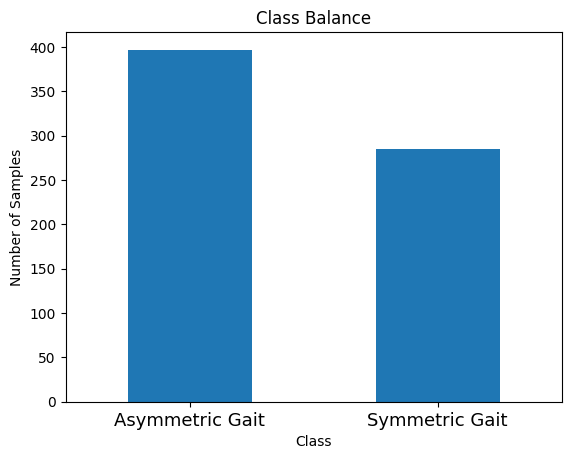

In [5]:
# Load Dataset
time_domain_data = pd.read_csv("detection_time_domain.csv")

# Filter for Gait Windows Only (label 0 or 1)
data_time_domain_gait = time_domain_data[time_domain_data['label_moderate'].isin([0, 1])].copy()
target_variable = 'label_moderate'

# Calculate class frequencies
class_counts = data_time_domain_gait[target_variable].value_counts()
bars = ['Asymmetric Gait', 'Symmetric Gait']
labels_position = np.arange(len(bars))


# Visualize class distribution
class_counts.plot(kind='bar')
plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(labels_position, bars, rotation=360, fontsize='13')
plt.show()


Training model: Random Forest
              precision    recall  f1-score   support

           0      0.522     0.537     0.529       361
           1      0.461     0.445     0.453       321

    accuracy                          0.494       682
   macro avg      0.491     0.491     0.491       682
weighted avg      0.493     0.494     0.494       682


Training model: Logistic Regression
              precision    recall  f1-score   support

           0      0.611     0.535     0.570       361
           1      0.541     0.617     0.576       321

    accuracy                          0.573       682
   macro avg      0.576     0.576     0.573       682
weighted avg      0.578     0.573     0.573       682


Training model: Gradient Boosting
              precision    recall  f1-score   support

           0      0.543     0.521     0.532       361
           1      0.485     0.508     0.496       321

    accuracy                          0.515       682
   macro avg      0.514  

,accuracy,f1_score_asymmetry,precision_asymmetry,recall_asymmetry
Logistic Regression,0.573314,0.576419,0.540984,0.616822
SVM (linear),0.535191,0.518968,0.505917,0.532710
Gradient Boosting,0.514663,0.496195,0.485119,0.507788
XGBoost,0.492669,0.462733,0.461300,0.464174
Random Forest,0.494135,0.453249,0.461290,0.445483
MLP,0.495601,0.452229,0.462541,0.442368


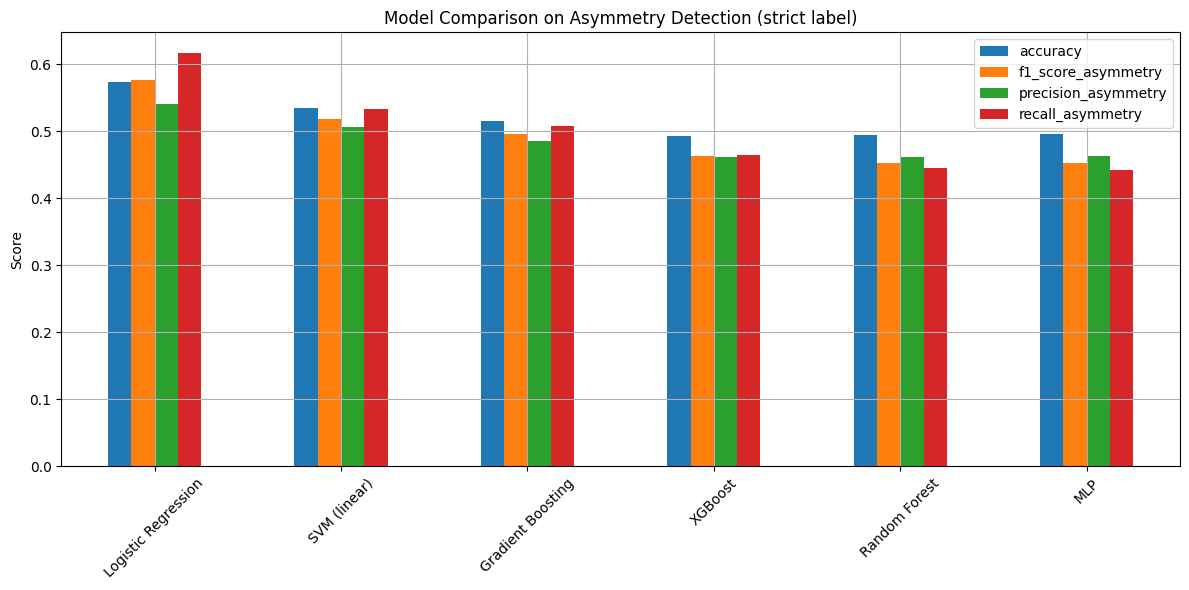


Training model: Random Forest
              precision    recall  f1-score   support

           0      0.385     0.340     0.361       285
           1      0.563     0.610     0.585       397

    accuracy                          0.497       682
   macro avg      0.474     0.475     0.473       682
weighted avg      0.488     0.497     0.492       682


Training model: Logistic Regression
              precision    recall  f1-score   support

           0      0.351     0.119     0.178       285
           1      0.571     0.841     0.680       397

    accuracy                          0.540       682
   macro avg      0.461     0.480     0.429       682
weighted avg      0.479     0.540     0.470       682


Training model: Gradient Boosting
              precision    recall  f1-score   support

           0      0.396     0.354     0.374       285
           1      0.569     0.612     0.590       397

    accuracy                          0.504       682
   macro avg      0.483  

,accuracy,f1_score_asymmetry,precision_asymmetry,recall_asymmetry
SVM (linear),0.570381,0.716908,0.581505,0.934509
Logistic Regression,0.539589,0.680244,0.570940,0.841310
MLP,0.527859,0.660338,0.568058,0.788413
XGBoost,0.535191,0.614824,0.593897,0.637280
Gradient Boosting,0.504399,0.589806,0.569087,0.612091
Random Forest,0.497067,0.585248,0.562791,0.609572


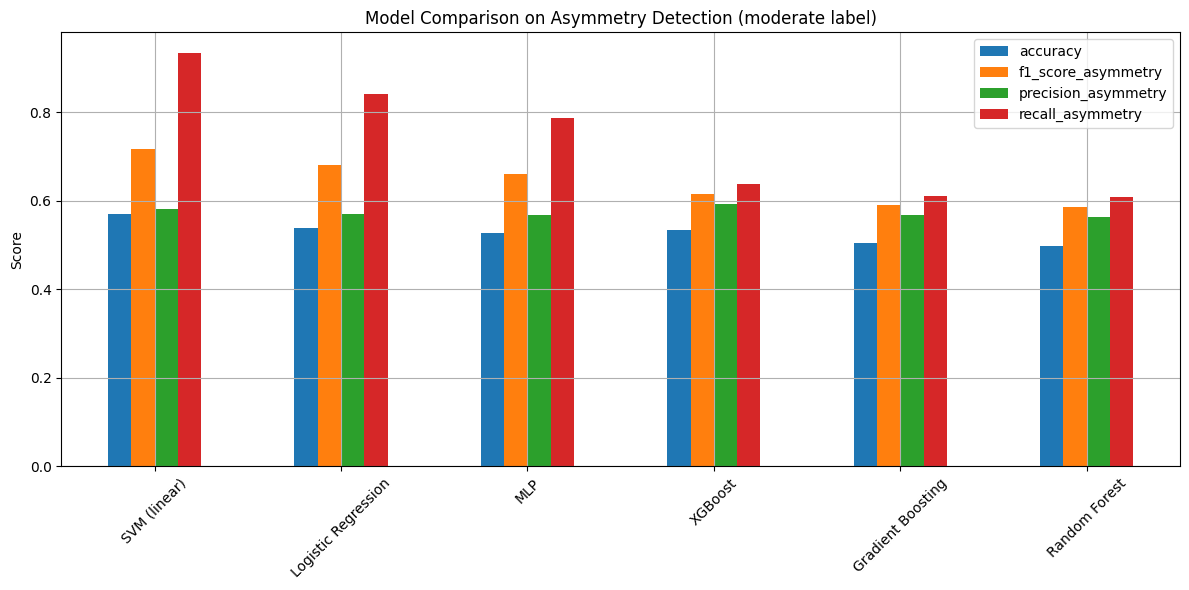


Training model: Random Forest
              precision    recall  f1-score   support

           0      0.186     0.056     0.086       197
           1      0.701     0.901     0.789       485

    accuracy                          0.657       682
   macro avg      0.444     0.478     0.437       682
weighted avg      0.553     0.657     0.586       682


Training model: Logistic Regression
              precision    recall  f1-score   support

           0      0.152     0.036     0.058       197
           1      0.701     0.920     0.796       485

    accuracy                          0.664       682
   macro avg      0.427     0.478     0.427       682
weighted avg      0.543     0.664     0.583       682


Training model: Gradient Boosting
              precision    recall  f1-score   support

           0      0.244     0.107     0.148       197
           1      0.705     0.866     0.777       485

    accuracy                          0.647       682
   macro avg      0.474  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

           0      0.213     0.132     0.163       197
           1      0.695     0.802     0.744       485

    accuracy                          0.609       682
   macro avg      0.454     0.467     0.454       682
weighted avg      0.556     0.609     0.577       682


 Model Comparison Summary:


,accuracy,f1_score_asymmetry,precision_asymmetry,recall_asymmetry
SVM (linear),0.711144,0.831191,0.711144,1.000000
MLP,0.675953,0.804252,0.704969,0.936082
Logistic Regression,0.664223,0.795718,0.701258,0.919588
Random Forest,0.656891,0.788809,0.701445,0.901031
Gradient Boosting,0.646628,0.777058,0.704698,0.865979
XGBoost,0.608504,0.744498,0.694643,0.802062


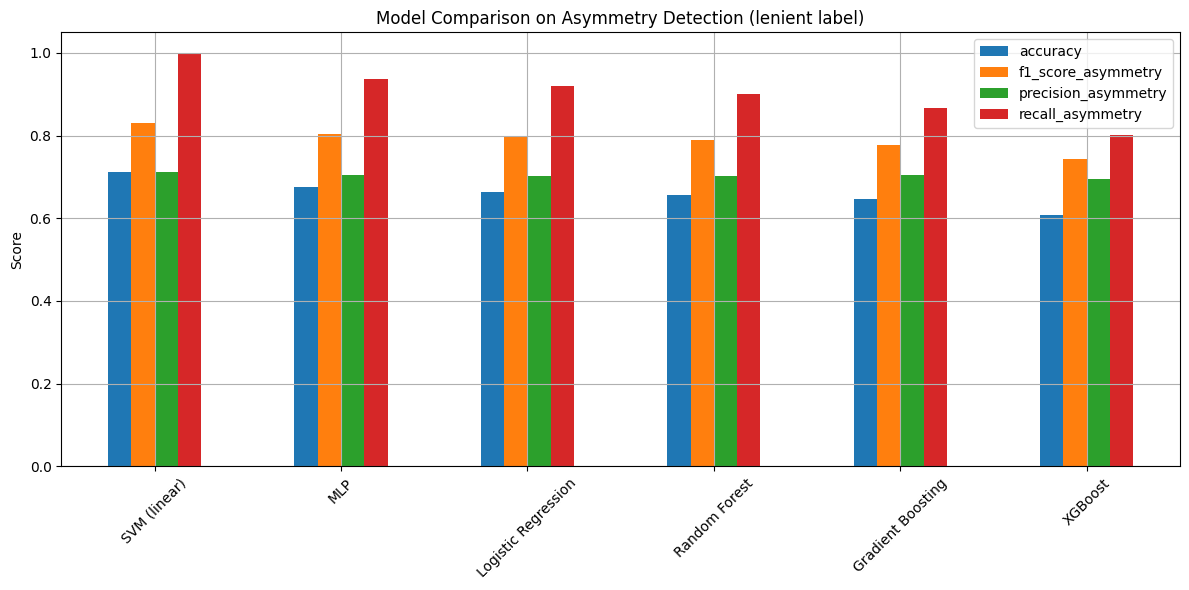

In [6]:
# Define Features and Labels
feature_cols = [
    'gyro-right-z-axis-max', 'gyro-left-z-axis-max',
    'gyro-right-z-axis-min', 'gyro-left-z-axis-min',
    'accel-right-z-axis-max', 'accel-left-z-axis-max',
    'accel-right-z-axis-min', 'accel-left-z-axis-min'
]

labels = ['label_strict', 'label_moderate', 'label_lenient']


for label in labels:
    label_type = label.split('_')[1]
    X = data_time_domain_gait[feature_cols].values
    y = data_time_domain_gait[label].values
    groups = data_time_domain_gait['patient_id'].values

    # Normalize Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Cross-Validation Setup
    gkf = GroupKFold(n_splits=5)

    # Define All Models to Compare
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Gradient Boosting": GradientBoostingClassifier(),
        "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=3000, alpha=1e-4),
        "SVM (linear)": SVC(kernel='linear', probability=True),
        "XGBoost": xgb.XGBClassifier(eval_metric='logloss')
    }


    # Train and Evaluate All Models
    results = {}

    for name, model in models.items():
        print(f"\nTraining model: {name}")
        y_true_all, y_pred_all = [], []

        # Training and Evaluation
        for fold, (train_idx, test_idx) in enumerate(gkf.split(X_scaled, y, groups)):
                model.fit(X_scaled[train_idx], y[train_idx])
                y_pred = model.predict(X_scaled[test_idx])
                y_true_all.extend(y[test_idx])
                y_pred_all.extend(y_pred)
                
        report = classification_report(y_true_all, y_pred_all, output_dict=True)
        results[name] = report
        print(classification_report(y_true_all, y_pred_all, digits=3))



    # Compare Models (Accuracy and F1)
    summary = pd.DataFrame({
        model: {
            "accuracy": results[model]["accuracy"],
            "f1_score_asymmetry": results[model]["1"]["f1-score"],
            "precision_asymmetry": results[model]["1"]["precision"],
            "recall_asymmetry": results[model]["1"]["recall"]
        }
        for model in results
    }).T


    summary = summary.sort_values(by="f1_score_asymmetry", ascending=False)
    print("\n Model Comparison Summary:")
    display(summary)

    # ## Plot Summary
    summary.plot(kind="bar", figsize=(12,6))
    plt.title(f"Model Comparison on Asymmetry Detection ({label_type} label)")
    plt.ylabel("Score")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Results 

| Label Type       | Behavior                                                 |
| ---------------- | -------------------------------------------------------- |
| `label_strict`   | Low recall, very few positive samples, ~60% performance  |
| `label_moderate` | Balanced but noisy performance                           |
| `label_lenient`  | Higher F1 and accuracy (~80%)                           |



### Why label_lenient Performs Better?

1. More positive-asymmetry samples:
    - The model has more training signal instances
    - Reduces the label sparsity between the two classes

2. Less ambiguous class boundaries:
    - Even mild asymmetry windows become "positives"

3. Possibly better idea in practice since:
    - Mild asymmetries do matter in stroke rehab
    - Detecting early signs may be more useful than catching only extreme events

<br><br/>
With the current solution we likely get:

- **More false positives**
- But also more opportunities for timely correction

A tradeoff we are willing to make in stroke patients rehab to ensure that even in smaller cases of asymmetry we provide opportunities for the user to correct the gait cycle.

## 2. Stride times Asymmetry values

In [7]:
# ## Define CNN Model Builder
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape),))
    model.add(Conv1D(64, 5, activation='relu', input_shape=input_shape), BatchNormalization)
    model.add(Conv1D(128, 3, activation='relu', input_shape=input_shape), BatchNormalization)
    model.add(Flatten(), Dense(64, activation='relu'), Dense(1, activation='sigmoid'))        
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
# CNN Model — Gait Asymmetry Detection from Raw IMU Windows

# Load the .npz dataset
data = np.load("all_subject_raw_windows.npz")
X = data["X"]
y = data["label_strict"]
groups = data["patient_id"]

# Filter out undefined gait cycle with label = 2
valid_idx = y != 2
X = X[valid_idx]
y = y[valid_idx]
groups = groups[valid_idx]

# Normalize per-feature
X = X.astype(np.float32)
X_mean = X.mean(axis=(0, 1), keepdims=True)
X_std = X.std(axis=(0, 1), keepdims=True)
X = (X - X_mean) / (X_std + 1e-7)

# GroupKFold Cross-Validation
gkf = GroupKFold(n_splits=5)
y_true_all, y_pred_all = [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\\nFold {fold + 1}")

    model = build_model(input_shape=X.shape[1:])
    history = model.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)

    y_pred_prob = model.predict(X[test_idx]).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    y_true_all.extend(y[test_idx])
    y_pred_all.extend(y_pred)

    print(classification_report(y[test_idx], y_pred, digits=3))

# Final Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Symmetric", "Asymmetric"], yticklabels=["Symmetric", "Asymmetric"])
plt.title("CNN — Gait Asymmetry Detection")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

\nFold 1


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TypeError: Sequential.add() takes from 2 to 3 positional arguments but 4 were given

## 3. Raw data values

In [ ]:
clean_extra_files(healthy_dir)
clean_extra_files(stroke_dir)